In [1]:
import numpy as np
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV, LeaveOneOut, StratifiedKFold

In [2]:
df_reponses = pd.read_csv(r'C:\Users\Axel\Desktop\projet stat\df_reponses.csv')
df_text_prop = pd.read_csv(r'C:\Users\Axel\Desktop\projet stat\clust.csv')
df_text_prop2=df_text_prop.loc[df_text_prop['txt_node_id'].isin(list(df_reponses['node_id']))]

In [3]:
data=pd.merge(df_reponses,df_text_prop, how='left', left_on='node_id',right_on='txt_node_id')
data.set_index('node_id',inplace=True)

#selection base par rapport à texte

liste_question=df_reponses.columns[1:]
liste_texte=df_text_prop.columns[1:]

In [4]:
compte=pd.DataFrame(df_text_prop2.sum(axis=0)).iloc[1:,:].sort_values(by=[0])
#On a 443 clients donc on cherche à supprimer les textes qui apparaissent chez moins de 10% des clients soit moins de 44 fois
compte.columns=['nombre']
liste_texte_non=list(compte.loc[compte['nombre']<40].index)
liste_texte_oui=list(compte.loc[compte['nombre']>=40].index)

In [17]:
#on supprime de la table les mauvais textes
data_clean=data.drop( columns=liste_texte_non)
#selection base par rapport à texte

liste_question=df_reponses.columns[1:]

In [6]:
compte.loc[compte['nombre']<40]

,nombre
2c90f58954c5d8340154ceac47be6917,0
d373944531fc4d1c0132013771dd1f01,0
d37394453afec751013b096eb3fd539f,0
d3739445342847c801342d3560da070b,0
ff8081816d652096016d71f9c0c613c0,0
...,...
2c90f5893faa3d37013faa42e7ea0404,39
d373944539678fdb013991e3446c5bdd,39
d373944534b518620134c32bc01203f3,39
d37394c529051639012912735c03099a,39


In [18]:
#exemple selection base texte 1
text1=liste_texte_oui[1000]
colonnes=list(liste_question)
colonnes.append(text1)
base_text1=data_clean[list(colonnes)]
base_text1[text1].value_counts()

0    278
1    165
Name: ff80818172e2fcb20172e52e5d2c11d7, dtype: int64

In [22]:
X_train, X_test, Y_train, Y_test= train_test_split(base_text1.iloc[:,0:-1], base_text1[text1],stratify=base_text1[text1], test_size=0.2,random_state=10)
Y_test.value_counts()

0    56
1    33
Name: ff80818172e2fcb20172e52e5d2c11d7, dtype: int64

In [23]:
# Returning to one dataframe
training_set = pd.concat([X_train, Y_train], axis=1)

# Separating classes
class1 = training_set[training_set[text1] == 1]
class0 = training_set[training_set[text1] == 0]

#Undersampling the majority
undersample = resample(class0, 
                       replace=True, 
                       n_samples=len(class1), #set the number of samples to equal the number of the minority class
                       random_state=10)
# Returning to new training set
undersample_train = pd.concat([class1, undersample])

# Separate undersampled data into X and y sets
x_train = undersample_train.drop(text1, axis=1)
y_train = undersample_train[text1]

y_train.value_counts()

1    132
0    132
Name: ff80818172e2fcb20172e52e5d2c11d7, dtype: int64

In [26]:
len(class1)

132

### Rnadom forest

{'max_depth': 9, 'max_features': 'auto', 'max_samples': 0.999, 'n_estimators': 200}
score apprentissage:1.0
score test:0.8181818181818182
1524.6006257534027


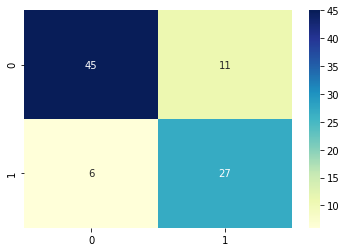

In [31]:
#on rajoute du boostrap dans les données
tps1 = time.time()
model=RandomForestClassifier(random_state=0)
max_feat=[0.02,0.05,0.08]+['auto']+[0.1,0.2]
max_samp=[0.5,0.7,0.999]
param={'n_estimators':[50,100,150,200],'max_depth':np.arange(1,10),'max_features':max_feat,"max_samples":max_samp}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0))
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [32]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.3707865168539326
[[ 0 56]
 [ 0 33]]

******** For i = 0.1 ******
Our testing accuracy is 0.39325842696629215
[[ 2 54]
 [ 0 33]]

******** For i = 0.15 ******
Our testing accuracy is 0.4157303370786517
[[ 4 52]
 [ 0 33]]

******** For i = 0.2 ******
Our testing accuracy is 0.47191011235955055
[[ 9 47]
 [ 0 33]]

******** For i = 0.25 ******
Our testing accuracy is 0.5955056179775281
[[20 36]
 [ 0 33]]

******** For i = 0.3 ******
Our testing accuracy is 0.651685393258427
[[26 30]
 [ 1 32]]

******** For i = 0.35 ******
Our testing accuracy is 0.7078651685393258
[[32 24]
 [ 2 31]]

******** For i = 0.4 ******
Our testing accuracy is 0.7640449438202247
[[38 18]
 [ 3 30]]

******** For i = 0.45 ******
Our testing accuracy is 0.797752808988764
[[43 13]
 [ 5 28]]

******** For i = 0.5 ******
Our testing accuracy is 0.8089887640449438
[[45 11]
 [ 6 27]]

******** For i = 0.55 ******
Our testing accuracy is 0.8089887640449438
[[47  9]
 [ 

{'max_depth': 9, 'n_estimators': 200}
score apprentissage:1.0
score test:0.8181818181818182
258.7171280384064


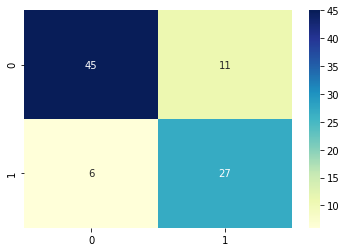

In [39]:
tps1 = time.time()
model=RandomForestClassifier(random_state=0)

param={'n_estimators':[100,150,200,250,300],'max_depth':np.arange(1,15)}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0))
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [40]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.3707865168539326
[[ 0 56]
 [ 0 33]]

******** For i = 0.1 ******
Our testing accuracy is 0.39325842696629215
[[ 2 54]
 [ 0 33]]

******** For i = 0.15 ******
Our testing accuracy is 0.4157303370786517
[[ 4 52]
 [ 0 33]]

******** For i = 0.2 ******
Our testing accuracy is 0.47191011235955055
[[ 9 47]
 [ 0 33]]

******** For i = 0.25 ******
Our testing accuracy is 0.5955056179775281
[[20 36]
 [ 0 33]]

******** For i = 0.3 ******
Our testing accuracy is 0.651685393258427
[[26 30]
 [ 1 32]]

******** For i = 0.35 ******
Our testing accuracy is 0.7078651685393258
[[32 24]
 [ 2 31]]

******** For i = 0.4 ******
Our testing accuracy is 0.7640449438202247
[[38 18]
 [ 3 30]]

******** For i = 0.45 ******
Our testing accuracy is 0.797752808988764
[[43 13]
 [ 5 28]]

******** For i = 0.5 ******
Our testing accuracy is 0.8089887640449438
[[45 11]
 [ 6 27]]

******** For i = 0.55 ******
Our testing accuracy is 0.8089887640449438
[[47  9]
 [ 

{'max_depth': 9, 'n_estimators': 200}
score apprentissage:1.0
score test:0.8181818181818182
167.50624442100525


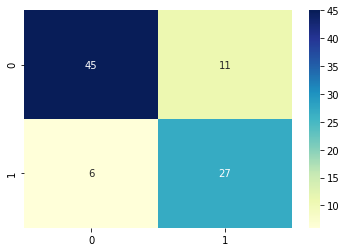

In [37]:
tps1 = time.time()
model=RandomForestClassifier(random_state=0)

param={'n_estimators':[100,150,200,250,300],'max_depth':np.arange(1,10)}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0),scoring='recall')
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [38]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.3707865168539326
[[ 0 56]
 [ 0 33]]

******** For i = 0.1 ******
Our testing accuracy is 0.39325842696629215
[[ 2 54]
 [ 0 33]]

******** For i = 0.15 ******
Our testing accuracy is 0.4157303370786517
[[ 4 52]
 [ 0 33]]

******** For i = 0.2 ******
Our testing accuracy is 0.47191011235955055
[[ 9 47]
 [ 0 33]]

******** For i = 0.25 ******
Our testing accuracy is 0.5955056179775281
[[20 36]
 [ 0 33]]

******** For i = 0.3 ******
Our testing accuracy is 0.651685393258427
[[26 30]
 [ 1 32]]

******** For i = 0.35 ******
Our testing accuracy is 0.7078651685393258
[[32 24]
 [ 2 31]]

******** For i = 0.4 ******
Our testing accuracy is 0.7640449438202247
[[38 18]
 [ 3 30]]

******** For i = 0.45 ******
Our testing accuracy is 0.797752808988764
[[43 13]
 [ 5 28]]

******** For i = 0.5 ******
Our testing accuracy is 0.8089887640449438
[[45 11]
 [ 6 27]]

******** For i = 0.55 ******
Our testing accuracy is 0.8089887640449438
[[47  9]
 [ 

### KNN

{'base_estimator__n_neighbors': 7, 'bootstrap_features': False, 'max_features': 0.1, 'n_estimators': 100}
score apprentissage:1.0
score test:0.7878787878787878
1344.2646815776825


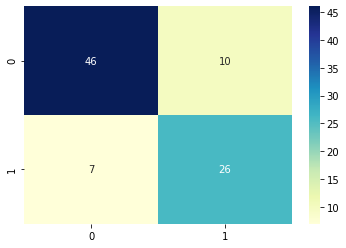

In [33]:
# on cherche simultanément les meilleurs paramètres pour le KNN et le bagging classifier
tps1 = time.time()
model=BaggingClassifier(base_estimator=KNeighborsClassifier(weights='distance'),random_state=0)
max_feat=[0.02,0.05,0.08,0.1]

param={'n_estimators':[50,80,100,150],'max_features':max_feat, 'base_estimator__n_neighbors':np.arange(1,11),"bootstrap_features":[True,False]}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0))
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [34]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.39325842696629215
[[ 2 54]
 [ 0 33]]

******** For i = 0.1 ******
Our testing accuracy is 0.42696629213483145
[[ 6 50]
 [ 1 32]]

******** For i = 0.15 ******
Our testing accuracy is 0.42696629213483145
[[ 7 49]
 [ 2 31]]

******** For i = 0.2 ******
Our testing accuracy is 0.47191011235955055
[[11 45]
 [ 2 31]]

******** For i = 0.25 ******
Our testing accuracy is 0.5168539325842697
[[15 41]
 [ 2 31]]

******** For i = 0.3 ******
Our testing accuracy is 0.6067415730337079
[[23 33]
 [ 2 31]]

******** For i = 0.35 ******
Our testing accuracy is 0.7191011235955056
[[33 23]
 [ 2 31]]

******** For i = 0.4 ******
Our testing accuracy is 0.7752808988764045
[[40 16]
 [ 4 29]]

******** For i = 0.45 ******
Our testing accuracy is 0.7752808988764045
[[41 15]
 [ 5 28]]

******** For i = 0.5 ******
Our testing accuracy is 0.8089887640449438
[[46 10]
 [ 7 26]]

******** For i = 0.55 ******
Our testing accuracy is 0.7865168539325843
[[48  8]

{'base_estimator__n_neighbors': 4, 'max_features': 0.7, 'n_estimators': 80}
score apprentissage:1.0
score test:0.8181818181818182
3400.5783224105835


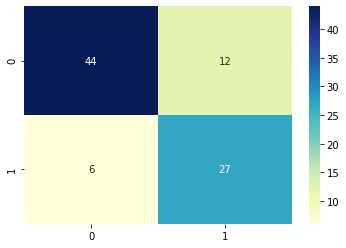

In [47]:
# on cherche simultanément les meilleurs paramètres pour le KNN et le bagging classifier
tps1 = time.time()
model=BaggingClassifier(base_estimator=KNeighborsClassifier(weights='distance'),random_state=0)
max_feat=[0.1,0.3,0.5,0.7,0.999]

param={'n_estimators':[50,80,100,150], 'base_estimator__n_neighbors':np.arange(1,11),'max_features':max_feat}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0))
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [48]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.4943820224719101
[[13 43]
 [ 2 31]]

******** For i = 0.1 ******
Our testing accuracy is 0.5280898876404494
[[17 39]
 [ 3 30]]

******** For i = 0.15 ******
Our testing accuracy is 0.5842696629213483
[[22 34]
 [ 3 30]]

******** For i = 0.2 ******
Our testing accuracy is 0.6179775280898876
[[26 30]
 [ 4 29]]

******** For i = 0.25 ******
Our testing accuracy is 0.6741573033707865
[[32 24]
 [ 5 28]]

******** For i = 0.3 ******
Our testing accuracy is 0.7191011235955056
[[36 20]
 [ 5 28]]

******** For i = 0.35 ******
Our testing accuracy is 0.7528089887640449
[[39 17]
 [ 5 28]]

******** For i = 0.4 ******
Our testing accuracy is 0.7528089887640449
[[39 17]
 [ 5 28]]

******** For i = 0.45 ******
Our testing accuracy is 0.7752808988764045
[[41 15]
 [ 5 28]]

******** For i = 0.5 ******
Our testing accuracy is 0.797752808988764
[[44 12]
 [ 6 27]]

******** For i = 0.55 ******
Our testing accuracy is 0.7752808988764045
[[44 12]
 [ 8

### log reg

{'bootstrap_features': True, 'max_features': 0.6, 'max_samples': 0.999, 'n_estimators': 10}
score apprentissage:0.946969696969697
score test:0.6666666666666666
350.2186596393585


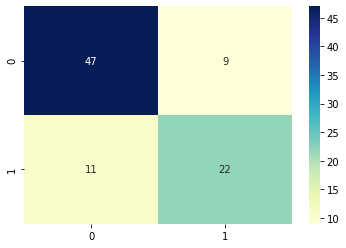

In [45]:
#avec boostrap
tps1 = time.time()
model=BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'),random_state=0)
max_feat=list(np.arange(0.1,1,0.1))
max_samp=[0.2,0.5,0.7,0.999]

param={'n_estimators':[10,20,50],'max_features':max_feat,"max_samples":max_samp,"bootstrap_features":[True,False]}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0),scoring='recall')
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [46]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.47191011235955055
[[ 9 47]
 [ 0 33]]

******** For i = 0.1 ******
Our testing accuracy is 0.5168539325842697
[[15 41]
 [ 2 31]]

******** For i = 0.15 ******
Our testing accuracy is 0.5730337078651685
[[21 35]
 [ 3 30]]

******** For i = 0.2 ******
Our testing accuracy is 0.5955056179775281
[[24 32]
 [ 4 29]]

******** For i = 0.25 ******
Our testing accuracy is 0.6292134831460674
[[27 29]
 [ 4 29]]

******** For i = 0.3 ******
Our testing accuracy is 0.6404494382022472
[[28 28]
 [ 4 29]]

******** For i = 0.35 ******
Our testing accuracy is 0.7078651685393258
[[36 20]
 [ 6 27]]

******** For i = 0.4 ******
Our testing accuracy is 0.7303370786516854
[[39 17]
 [ 7 26]]

******** For i = 0.45 ******
Our testing accuracy is 0.7640449438202247
[[44 12]
 [ 9 24]]

******** For i = 0.5 ******
Our testing accuracy is 0.7752808988764045
[[47  9]
 [11 22]]

******** For i = 0.55 ******
Our testing accuracy is 0.7640449438202247
[[47  9]
 [

{'max_features': 0.30000000000000004, 'n_estimators': 20}
score apprentissage:0.9696969696969697
score test:0.696969696969697
52.02302813529968


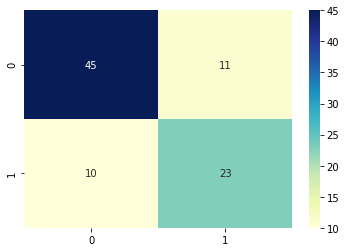

In [49]:
#sans boostrap
tps1 = time.time()
model=BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'),random_state=0)
max_feat=list(np.arange(0.1,1,0.1))


param={'n_estimators':[5,8,10,20,50],'max_features':max_feat}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0))
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [50]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.43820224719101125
[[ 6 50]
 [ 0 33]]

******** For i = 0.1 ******
Our testing accuracy is 0.48314606741573035
[[11 45]
 [ 1 32]]

******** For i = 0.15 ******
Our testing accuracy is 0.550561797752809
[[17 39]
 [ 1 32]]

******** For i = 0.2 ******
Our testing accuracy is 0.5955056179775281
[[22 34]
 [ 2 31]]

******** For i = 0.25 ******
Our testing accuracy is 0.6853932584269663
[[31 25]
 [ 3 30]]

******** For i = 0.3 ******
Our testing accuracy is 0.7415730337078652
[[36 20]
 [ 3 30]]

******** For i = 0.35 ******
Our testing accuracy is 0.7415730337078652
[[37 19]
 [ 4 29]]

******** For i = 0.4 ******
Our testing accuracy is 0.7865168539325843
[[42 14]
 [ 5 28]]

******** For i = 0.45 ******
Our testing accuracy is 0.7752808988764045
[[43 13]
 [ 7 26]]

******** For i = 0.5 ******
Our testing accuracy is 0.7640449438202247
[[45 11]
 [10 23]]

******** For i = 0.55 ******
Our testing accuracy is 0.7752808988764045
[[47  9]
 [

### SVM

{'base_estimator__C': 0.01, 'base_estimator__degree': 2, 'base_estimator__kernel': 'poly', 'bootstrap_features': True, 'max_features': 0.8, 'max_samples': 0.7, 'n_estimators': 10}
score apprentissage:0.0
score test:0.0
15549.222067832947


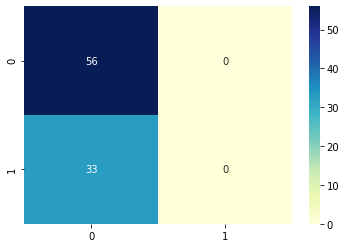

In [53]:
tps1 = time.time()
model=BaggingClassifier(base_estimator=SVC(),random_state=0)
max_feat=[0.2,0.5,0.8,0.999]
max_samp=[0.5,0.7,0.999]

param={'n_estimators':[10,20,50,80,100],'max_features':max_feat,"max_samples":max_samp,"bootstrap_features":[True,False],'base_estimator__C':[0.01,1,100],'base_estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],'base_estimator__degree':[2,3]}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0),scoring='recall')
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [54]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.3707865168539326
[[ 0 56]
 [ 0 33]]

******** For i = 0.1 ******
Our testing accuracy is 0.3707865168539326
[[ 0 56]
 [ 0 33]]

******** For i = 0.15 ******
Our testing accuracy is 0.3707865168539326
[[ 0 56]
 [ 0 33]]

******** For i = 0.2 ******
Our testing accuracy is 0.3707865168539326
[[ 0 56]
 [ 0 33]]

******** For i = 0.25 ******
Our testing accuracy is 0.3707865168539326
[[ 0 56]
 [ 0 33]]

******** For i = 0.3 ******
Our testing accuracy is 0.6292134831460674
[[56  0]
 [33  0]]

******** For i = 0.35 ******
Our testing accuracy is 0.6292134831460674
[[56  0]
 [33  0]]

******** For i = 0.4 ******
Our testing accuracy is 0.6292134831460674
[[56  0]
 [33  0]]

******** For i = 0.45 ******
Our testing accuracy is 0.6292134831460674
[[56  0]
 [33  0]]

******** For i = 0.5 ******
Our testing accuracy is 0.6292134831460674
[[56  0]
 [33  0]]

******** For i = 0.55 ******
Our testing accuracy is 0.6292134831460674
[[56  0]
 [3

### KNN sans bagging

{'n_neighbors': 14}
score apprentissage:1.0
score test:0.875
1.8414943218231201


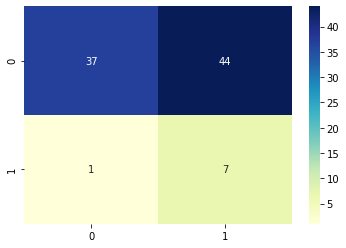

In [28]:
tps1 = time.time()
model=KNeighborsClassifier(weights='distance')


param={'n_neighbors':np.arange(1,20)}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0))
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [29]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.1 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.15 ******
Our testing accuracy is 0.11235955056179775
[[ 2 79]
 [ 0  8]]

******** For i = 0.2 ******
Our testing accuracy is 0.11235955056179775
[[ 2 79]
 [ 0  8]]

******** For i = 0.25 ******
Our testing accuracy is 0.1348314606741573
[[ 4 77]
 [ 0  8]]

******** For i = 0.3 ******
Our testing accuracy is 0.2808988764044944
[[18 63]
 [ 1  7]]

******** For i = 0.35 ******
Our testing accuracy is 0.3258426966292135
[[22 59]
 [ 1  7]]

******** For i = 0.4 ******
Our testing accuracy is 0.3595505617977528
[[25 56]
 [ 1  7]]

******** For i = 0.45 ******
Our testing accuracy is 0.4606741573033708
[[34 47]
 [ 1  7]]

******** For i = 0.5 ******
Our testing accuracy is 0.4943820224719101
[[37 44]
 [ 1  7]]

******** For i = 0.55 ******
Our testing accuracy is 0.5617977528089888
[[43 38]
 

{'n_neighbors': 10}
score apprentissage:1.0
score test:0.875
1.2073323726654053


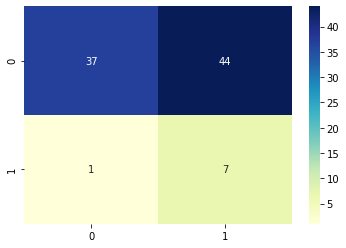

In [30]:
tps1 = time.time()
model=KNeighborsClassifier(weights='distance')


param={'n_neighbors':np.arange(1,15)}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0),scoring='recall')
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

### SVC sans bagging

{'C': 1, 'degree': 3, 'kernel': 'poly'}
score apprentissage:1.0
score test:0.875
4.2396018505096436


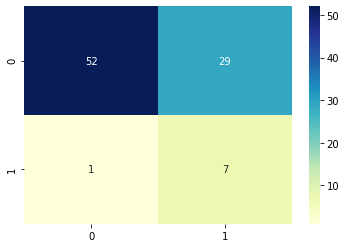

In [31]:
tps1 = time.time()
model=SVC(probability=True)


param={'C':[0.01,1,100],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[2,3]}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0))
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [32]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.1 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.15 ******
Our testing accuracy is 0.1348314606741573
[[ 4 77]
 [ 0  8]]

******** For i = 0.2 ******
Our testing accuracy is 0.16853932584269662
[[ 7 74]
 [ 0  8]]

******** For i = 0.25 ******
Our testing accuracy is 0.24719101123595505
[[15 66]
 [ 1  7]]

******** For i = 0.3 ******
Our testing accuracy is 0.29213483146067415
[[19 62]
 [ 1  7]]

******** For i = 0.35 ******
Our testing accuracy is 0.3707865168539326
[[26 55]
 [ 1  7]]

******** For i = 0.4 ******
Our testing accuracy is 0.5056179775280899
[[38 43]
 [ 1  7]]

******** For i = 0.45 ******
Our testing accuracy is 0.5955056179775281
[[46 35]
 [ 1  7]]

******** For i = 0.5 ******
Our testing accuracy is 0.6629213483146067
[[52 29]
 [ 1  7]]

******** For i = 0.55 ******
Our testing accuracy is 0.7303370786516854
[[60 21]


{'C': 100, 'degree': 2, 'kernel': 'poly'}
score apprentissage:1.0
score test:0.625
4.4106574058532715


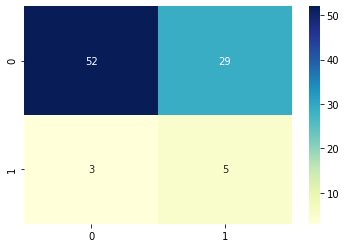

In [33]:
tps1 = time.time()
model=SVC(probability=True)


param={'C':[0.01,1,100],'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[2,3]}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0),scoring='recall')
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [34]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.1 ******
Our testing accuracy is 0.11235955056179775
[[ 2 79]
 [ 0  8]]

******** For i = 0.15 ******
Our testing accuracy is 0.15730337078651685
[[ 6 75]
 [ 0  8]]

******** For i = 0.2 ******
Our testing accuracy is 0.21348314606741572
[[12 69]
 [ 1  7]]

******** For i = 0.25 ******
Our testing accuracy is 0.24719101123595505
[[15 66]
 [ 1  7]]

******** For i = 0.3 ******
Our testing accuracy is 0.33707865168539325
[[23 58]
 [ 1  7]]

******** For i = 0.35 ******
Our testing accuracy is 0.4606741573033708
[[34 47]
 [ 1  7]]

******** For i = 0.4 ******
Our testing accuracy is 0.5280898876404494
[[40 41]
 [ 1  7]]

******** For i = 0.45 ******
Our testing accuracy is 0.6179775280898876
[[48 33]
 [ 1  7]]

******** For i = 0.5 ******
Our testing accuracy is 0.6404494382022472
[[52 29]
 [ 3  5]]

******** For i = 0.55 ******
Our testing accuracy is 0.6741573033707865
[[56 25

### log reg sans boost

D:\programme\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
D:\programme\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
D:\programme\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
D:\programme\anaconda\lib\site-packages\sklearn\li

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
score apprentissage:0.8823529411764706
score test:0.875
7.846543788909912


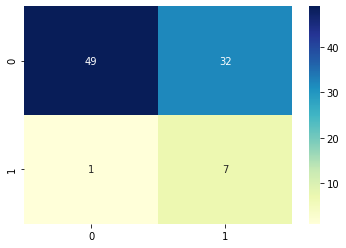

In [35]:
#sans boostrap
tps1 = time.time()
model=LogisticRegression()



param={'penalty':['l1', 'l2', 'elasticnet'],'C':[0.01,1,100],'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0))
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [36]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.1 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.15 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.2 ******
Our testing accuracy is 0.0898876404494382
[[ 0 81]
 [ 0  8]]

******** For i = 0.25 ******
Our testing accuracy is 0.12359550561797752
[[ 3 78]
 [ 0  8]]

******** For i = 0.3 ******
Our testing accuracy is 0.16853932584269662
[[ 8 73]
 [ 1  7]]

******** For i = 0.35 ******
Our testing accuracy is 0.23595505617977527
[[14 67]
 [ 1  7]]

******** For i = 0.4 ******
Our testing accuracy is 0.3595505617977528
[[25 56]
 [ 1  7]]

******** For i = 0.45 ******
Our testing accuracy is 0.48314606741573035
[[36 45]
 [ 1  7]]

******** For i = 0.5 ******
Our testing accuracy is 0.6292134831460674
[[49 32]
 [ 1  7]]

******** For i = 0.55 ******
Our testing accuracy is 0.8089887640449438
[[66 15]

D:\programme\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
D:\programme\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
D:\programme\anaconda\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
D:\programme\anaconda\lib\site-packages\sklearn\li

{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
score apprentissage:1.0
score test:0.75
7.840746641159058


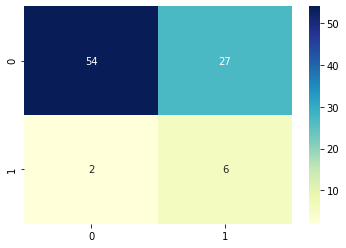

In [37]:
#sans boostrap
tps1 = time.time()
model=LogisticRegression()



param={'penalty':['l1', 'l2', 'elasticnet'],'C':[0.01,1,100],'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid=GridSearchCV(model,param,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=0),scoring='recall')
grid.fit(x_train,y_train)
print(grid.best_params_)
model1=grid.best_estimator_


print("score apprentissage:{}".format(recall_score(y_train,model1.predict(x_train))))           
print("score test:{}".format(recall_score(Y_test,model1.predict(X_test)))) 


mat=confusion_matrix(Y_test, model1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")
tps2 = time.time()
print(tps2 - tps1)

In [38]:
pred_proba_df = pd.DataFrame(model1.predict_proba(X_test))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
Y_test=pd.DataFrame(Y_test)
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = accuracy_score(Y_test,Y_test_pred[1])
    
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(Y_test,Y_test_pred[1]))


******** For i = 0.05 ******
Our testing accuracy is 0.15730337078651685
[[ 7 74]
 [ 1  7]]

******** For i = 0.1 ******
Our testing accuracy is 0.23595505617977527
[[14 67]
 [ 1  7]]

******** For i = 0.15 ******
Our testing accuracy is 0.3258426966292135
[[22 59]
 [ 1  7]]

******** For i = 0.2 ******
Our testing accuracy is 0.38202247191011235
[[27 54]
 [ 1  7]]

******** For i = 0.25 ******
Our testing accuracy is 0.449438202247191
[[33 48]
 [ 1  7]]

******** For i = 0.3 ******
Our testing accuracy is 0.5168539325842697
[[39 42]
 [ 1  7]]

******** For i = 0.35 ******
Our testing accuracy is 0.5842696629213483
[[45 36]
 [ 1  7]]

******** For i = 0.4 ******
Our testing accuracy is 0.6067415730337079
[[48 33]
 [ 2  6]]

******** For i = 0.45 ******
Our testing accuracy is 0.6404494382022472
[[51 30]
 [ 2  6]]

******** For i = 0.5 ******
Our testing accuracy is 0.6741573033707865
[[54 27]
 [ 2  6]]

******** For i = 0.55 ******
Our testing accuracy is 0.6741573033707865
[[55 26]
 